## run this cell before starting spark cluster connection (corrects module error)

In [1]:
import os
print os.environ['PYSPARK_PYTHON']
os.environ['PYSPARK_PYTHON']=os.environ['LCG_VIEW'] + '/bin/python'
print os.environ['PYSPARK_PYTHON']

/etc/spark/python
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/bin/python


### Import necessary spark and python stuff

In [2]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import from_json
from pyspark.ml.feature import VectorAssembler

In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### select the data

In [4]:
df = spark.read.json("/user/rucio01/traces/traces.2018-05*")

### Create temporary table view

In [5]:
df.createOrReplaceTempView("traces")

### Use PySpark to query download events and split dataset DID into new features

In [6]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)

### Official Data Only

In [7]:
df_ps = spark.sql("SELECT *\
                   FROM traces \
                   WHERE eventType=='download' AND clientState != 'ALREADY_DONE' AND dataset != 'None' AND dataset != '' AND dataset != '[null]' AND account != 'pilot' AND (dataset LIKE 'data%' OR dataset LIKE 'mc%')")

In [8]:
df_ps.describe().toPandas()

summary _corrupt_record   account appid catStart         clientState  \
0  count   0               591845    0     0        591845               
1  mean    None            None      None  None     None                 
2  stddev  None            None      None  None     None                 
3  min     None            abell     None  None     CannotAuthenticate   
4  max     None            zmarshal  None  None     SourceNotFound       

                                                                                           dataset  \
0  591845                                                                                            
1  None                                                                                              
2  None                                                                                              
3  data12_8TeV.00200805.physics_MinBias.recon.NTUP_MINBIAS.r4768                                     
4  mc16_valid.361034.Pythia8EvtGen_A2MSTW2008LO_minbias_inelastic_low.merge.HITS.e3581_s3028_s2939   

  datasetName datasetScope dataset_scope  duid eventType        eventVersion  \
0  0           591845       0             0     591845    591845               
1  None        None         None          None  None      None                 
2  None        None         None          None  None      None                 
3  None        data12_8TeV  None          None  download  1.14.10              
4  None        mc16_valid   None          None  download  webui_1.16.0.post1   

                             filename              filesize  guid  \
0  591656                              591845                0      
1  None                                1.4308087476686785E9  None   
2  None                                2.189936936508773E9   None   
3  AOD.05341490._000446.pool.root.1    10000                 None   
4  log.14217468._003414.job.log.tgz.1  99999162              None   

                   hostname    ip localSite  \
0  591832                    0     0          
1  None                      None  None       
2  None                      None  None       
3  ReCaS-ui-01.cs.infn.it    None  None       
4  xenia.nevis.columbia.edu  None  None       

                                       name    pq protocol relativeStart  \
0  189                                       0     591845   0              
1  None                                      None  None     None           
2  None                                      None  None     None           
3  NTUP_PILEUP.11325280._000001.pool.root.1  None  davs     None           
4  NTUP_PILEUP.13279990._000009.pool.root.1  None  srm      None           

                  remoteSite   rse        scope stateReason suspicious taskid  \
0  591845                     0     591845       0           0          0       
1  None                       None  None         None        None       None    
2  None                       None  None         None        None       None    
3  AGLT2_CALIBDISK            None  data12_8TeV  None        None       None    
4  WUPPERTALPROD_SCRATCHDISK  None  mc16_valid   None        None       None    

  timeEnd timeStart                           traceId  \
0  0       0         591845                             
1  None    None      None                               
2  None    None      None                               
3  None    None      000006b4ce98452580a7493dba70ceb0   
4  None    None      ffffd5de42064e778bb14610ca50b1a6   

                     traceIp              traceTimeentry  \
0  591845                     591845                       
1  None                       None                         
2  None                       None                         
3  2001:1458:201:e4::100:28c  2018-04-30T22:00:33.301146   
4  ::ffff:91.239.204.45       2018-05-31T21:59:47.107225   

     traceTimeentryUnix          transferEnd         transferStart   url  \
0  591845                368549          

### drop columns that do not contain any values (or very little values, like 'name') based on previous describe()

In [9]:
df_ps = df_ps.drop('appid', 'catStart', 'datasetName', 'dataset_scope', 'duid', 
                   'guid', 'ip', 'localSite', 'pq', 'relativeStart', 'stateReason', 
                   'suspicious', 'taskid', 'timeEnd', 'timeStart', 'url', 'usr', 
                   'usrdn', 'validateStart', 'version', 'name')

## Drop empty Mai columns

In [10]:
df_ps = df_ps.drop('_corrupt_record', 'rse')

In [11]:
df_ps.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_ps.columns]).limit(10).toPandas()

account  clientState  dataset  datasetScope  eventType  eventVersion  \
0  0        0            0        0             0          0              

   filename  filesize  hostname  protocol  remoteSite  scope  traceId  \
0  189       0         13        0         0           0      0         

   traceIp  traceTimeentry  traceTimeentryUnix  transferEnd  transferStart  \
0  0        0               0                   223296       13              

   uuid  
0  0

## Split dataset column

In [12]:
split_col = split(df_ps['dataset'], "\.")
df_ps = df_ps.withColumn('project', split_col.getItem(0))
df_ps = df_ps.withColumn('run_number', split_col.getItem(1))
df_ps = df_ps.withColumn('stream_name', split_col.getItem(2))
df_ps = df_ps.withColumn('prod_step', split_col.getItem(3))
df_ps = df_ps.withColumn('datatype', split_col.getItem(4))
df_ps = df_ps.withColumn('dataset_version', split_col.getItem(5))

In [13]:
df_ps.describe().toPandas()

summary   account         clientState  \
0  count   591845    591845               
1  mean    None      None                 
2  stddev  None      None                 
3  min     abell     CannotAuthenticate   
4  max     zmarshal  SourceNotFound       

                                                                                           dataset  \
0  591845                                                                                            
1  None                                                                                              
2  None                                                                                              
3  data12_8TeV.00200805.physics_MinBias.recon.NTUP_MINBIAS.r4768                                     
4  mc16_valid.361034.Pythia8EvtGen_A2MSTW2008LO_minbias_inelastic_low.merge.HITS.e3581_s3028_s2939   

  datasetScope eventType        eventVersion  \
0  591845       591845    591845               
1  None         None      None                 
2  None         None      None                 
3  data12_8TeV  download  1.14.10              
4  mc16_valid   download  webui_1.16.0.post1   

                             filename              filesize  \
0  591656                              591845                 
1  None                                1.4308087476686785E9   
2  None                                2.1899369365087786E9   
3  AOD.05341490._000446.pool.root.1    10000                  
4  log.14217468._003414.job.log.tgz.1  99999162               

                   hostname protocol                 remoteSite        scope  \
0  591832                    591845   591845                     591845        
1  None                      None     None                       None          
2  None                      None     None                       None          
3  ReCaS-ui-01.cs.infn.it    davs     AGLT2_CALIBDISK            data12_8TeV   
4  xenia.nevis.columbia.edu  srm      WUPPERTALPROD_SCRATCHDISK  mc16_valid    

                            traceId                    traceIp  \
0  591845                            591845                      
1  None                              None                        
2  None                              None                        
3  000006b4ce98452580a7493dba70ceb0  2001:1458:201:e4::100:28c   
4  ffffd5de42064e778bb14610ca50b1a6  ::ffff:91.239.204.45        

               traceTimeentry    traceTimeentryUnix           transferEnd  \
0  591845                      591845                368549                 
1  None                        1.5261971375340571E9  1.5262180473443456E9   
2  None                        718455.2485791768     700848.912553818       
3  2018-04-30T22:00:33.301146  1.525125633301146E9   1.525125634043446E9    
4  2018-05-31T21:59:47.107225  1.527803987107225E9   1.527803986849469E9    

          transferStart                              uuid      project  \
0  591832                591845                            591845        
1  1.5261970457356315E9  None                              None          
2  718450.7659714553     None                              None          
3  1.524860531819739E9   000397830f284c508523b44ed7d19aab  data12_8TeV   
4  1.527803946887522E9   fffe0a61b053499da59d19fa07de8bbd  mc16_valid    

           run_number                                  stream_name prod_step  \
0  591845              591845                                       591845     
1  350074.32882978953  None                                         None       
2  47664.21312726827   None                                         None       
3  00200805            AlpgenJimmy_AUET2_CTEQ6L1_WenugammagammaNp0  PhysCont   
4  periodL             physics_ZeroBias                             simul      

  datatype dataset_version  
0  591845   589484          
1  None     None            
2  None     None            
3  AOD      c1128_m1842     
4  log      x563_m1972

In [14]:
df_ps.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_ps.columns]).limit(10).toPandas()

account  clientState  dataset  datasetScope  eventType  eventVersion  \
0  0        0            0        0             0          0              

   filename  filesize  hostname  protocol  remoteSite  scope  traceId  \
0  189       0         13        0         0           0      0         

   traceIp  traceTimeentry  traceTimeentryUnix  transferEnd  transferStart  \
0  0        0               0                   223296       13              

   uuid  project  run_number  stream_name  prod_step  datatype  \
0  0     0        0           0            0          0          

   dataset_version  
0  2361

## Drop transferend due to many missing values

In [15]:
df_ps = df_ps.drop('transferEnd')

In [16]:
df_ps = df_ps.dropna()

In [17]:
df_ps.createOrReplaceTempView("df_ps")

### Count dataset hits and join both tables

In [18]:
df_ps_counts = spark.sql("SELECT filename AS file_counts, count(*) as hits \
                               FROM traces \
                               WHERE eventType=='download' AND clientState != 'ALREADY_DONE' AND dataset != 'None' AND dataset != '' AND dataset != '[null]' AND account != 'pilot' AND (dataset LIKE 'data%' OR dataset LIKE 'mc%')\
                               GROUP BY  filename \
                               ORDER BY 2 DESC")

In [19]:
df_ps_counts.createOrReplaceTempView("counts")

In [20]:
df_ps_merged = spark.sql("SELECT * \
                               FROM df_ps \
                               INNER JOIN counts ON df_ps.filename = counts.file_counts")

In [21]:
df_ps_merged = df_ps_merged.drop('file_counts')

In [22]:
# refresh merged view so that all columns are in it
df_ps_merged.createOrReplaceTempView("merged")

In [23]:
df_ps_merged.count()

589283

## cast filesize and run_number to double

In [24]:
df_ps_final = df_ps_merged.withColumn("filesize_double",df_ps_merged.filesize.cast(DoubleType()))

In [25]:
df_ps_final = df_ps_final.drop('filesize')

In [26]:
df_ps_final.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_ps_final.columns]).limit(10).toPandas()

account  clientState  dataset  datasetScope  eventType  eventVersion  \
0  0        0            0        0             0          0              

   filename  hostname  protocol  remoteSite  scope  traceId  traceIp  \
0  0         0         0         0           0      0        0         

   traceTimeentry  traceTimeentryUnix  transferStart  uuid  project  \
0  0               0                   0              0     0         

   run_number  stream_name  prod_step  datatype  dataset_version  hits  \
0  0           0            0          0         0                0      

   filesize_double  
0  0

In [27]:
df_ps_final = df_ps_final.dropna()

In [28]:
df_ps_final.count()

589283

In [29]:
df_ps_final.describe().toPandas()

summary   account         clientState  \
0  count   589283    589283               
1  mean    None      None                 
2  stddev  None      None                 
3  min     abell     CannotAuthenticate   
4  max     zmarshal  SourceNotFound       

                                                                                           dataset  \
0  589283                                                                                            
1  None                                                                                              
2  None                                                                                              
3  data12_8TeV.00200805.physics_MinBias.recon.NTUP_MINBIAS.r4768                                     
4  mc16_valid.361034.Pythia8EvtGen_A2MSTW2008LO_minbias_inelastic_low.merge.HITS.e3581_s3028_s2939   

  datasetScope eventType eventVersion                            filename  \
0  589283       589283    589283       589283                               
1  None         None      None         None                                 
2  None         None      None         None                                 
3  data12_8TeV  download  1.14.10      AOD.05341490._000446.pool.root.1     
4  mc16_valid   download  1.16.1       log.14217468._003414.job.log.tgz.1   

                   hostname protocol                 remoteSite        scope  \
0  589283                    589283   589283                     589283        
1  None                      None     None                       None          
2  None                      None     None                       None          
3  ReCaS-ui-01.cs.infn.it    davs     AGLT2_CALIBDISK            data12_8TeV   
4  xenia.nevis.columbia.edu  srm      WUPPERTALPROD_SCRATCHDISK  mc16_valid    

                            traceId                    traceIp  \
0  589283                            589283                      
1  None                              None                        
2  None                              None                        
3  000006b4ce98452580a7493dba70ceb0  2001:1458:201:e4::100:28c   
4  ffffd5de42064e778bb14610ca50b1a6  ::ffff:91.239.204.45        

               traceTimeentry    traceTimeentryUnix         transferStart  \
0  589283                      589283                589283                 
1  None                        1.5261951742501495E9  1.5261950767825074E9   
2  None                        716920.458291758      716914.0264712706      
3  2018-04-30T22:00:33.301146  1.525125633301146E9   1.524860531819739E9    
4  2018-05-31T21:59:47.107225  1.527803987107225E9   1.527803946887522E9    

                               uuid      project         run_number  \
0  589283                            589283       589283              
1  None                              None         350085.3422377267   
2  None                              None         47777.01099327565   
3  000397830f284c508523b44ed7d19aab  data12_8TeV  00200805            
4  fffe0a61b053499da59d19fa07de8bbd  mc16_valid   periodL             

                                   stream_name prod_step datatype  \
0  589283                                       589283    589283    
1  None                                         None      None      
2  None                                         None      None      
3  AlpgenJimmy_AUET2_CTEQ6L1_WenugammagammaNp0  PhysCont  AOD       
4  physics_ZeroBias                             simul     log       

  dataset_version               hits       filesize_double  
0  589283          589283             589283                
1  None            4.395322790577702  1.4339739956710258E9  
2  None            6.041694435706448  2.1931399445812E9     
3  c1128_m1842     1                  9576.0                
4  x563_m1972      85                 1.1976018886E10

In [30]:
df_ps_final.createOrReplaceTempView("final")
df_hits = spark.sql("SELECT hits, count(*) \
                     FROM final \
                     GROUP BY hits")
df_hits_pd = df_hits.toPandas()

In [31]:
spark.sql("SELECT account, count(*) \
            FROM traces \
            WHERE eventType=='download' AND clientState != 'ALREADY_DONE' AND dataset != 'None' AND dataset != '' AND dataset != '[null]' AND account != 'pilot' AND (dataset LIKE 'data%' OR dataset LIKE 'mc%')\
            GROUP BY  account \
            ORDER BY 1 DESC").toPandas()

account  count(1)
0    zmarshal    2       
1    zhelun      932     
2    zhangb      12      
3    zenon       34      
4    zchadi      4       
5    yyap        1638    
6    yunju       29      
7    yuchengh    3027    
8    yuchen      2       
9    yshimoga    3       
10   ysano       112180  
11   ysaboo      11      
12   yqi         111     
13   yoyamagu    10      
14   ynoguchi    3       
15   ylo         266     
16   ykeisuke    7       
17   yilin       19      
18   yifang      4       
19   yhang       80      
20   yfukuhar    21      
21   yfhu        29      
22   yelghaza    6       
23   ychow       363     
24   ychiu       221     
25   yabulait    2       
26   xulou       15      
27   xella       1       
28   wyswys      3       
29   woodsn      1525    
30   wichan      5667    
31   wheidorn    1       
32   wdicleme    3       
33   wbarbe      134     
34   walkerr     572     
35   waislam     108     
36   wachan      6       
37   vvecchio    14      
38   vlang       1       
39   vkost       8       
40   vkitali     2925    
41   vippolit    5       
42   vdao        5       
43   vbailey     1       
44   vanjam      3277    
45   valentem    129     
46   vacavant    7       
47   uysasmaz    1       
48   umartens    8       
49   tzakarei    1       
50   tweston     102     
51   tuna        5551    
52   tsakai      51      
53   truggeri    93      
54   tpowell     197     
55   tpoulsen    1       
56   toyamaza    19893   
57   toshi       1       
58   tomoe       5       
59   tofitsch    1       
60   todorova    12      
61   tnobe       269     
62   tnitta      15      
63   tneep       20      
64   tmeideck    22      
65   tlari       39      
66   tkwan       60      
67   tkaji       15270   
68   thompson    9       
69   tholmes     2       
70   tholm       6       
71   thmegy      1       
72   therwig     6       
73   tburch      10      
74   tbeerman    1       
75   tatsuya     161     
76   tapark      1       
77   tamartin    3       
78   tadej       8       
79   szambito    2024    
80   suyogs      11      
81   sutt        42      
82   susingh     52      
83   stsuno      1       
84   sthais      3       
85   stephen     508     
86   sspinali    115     
87   ssolomon    791     
88   sshirabe    99      
89   sshaw       1       
90   ssantpur    25      
91   sraspopo    1       
92   spieker     24      
93   sosen       504     
94   smazza      49      
95   smanzoni    6       
96   sketabch    8       
97   sjiggins    3       
98   sisilva     228     
99   sidoti      2       
100  shuzhou     1       
101  shuangge    131     
102  shion       540     
103  shhirose    2       
104  shhan       11      
105  sfrances    100     
106  sferguso    1       
107  sdysch      3       
108  sdahbi      7       
109  schsu       233     
110  scheong     19      
111  scheiric    34      
112  sche        13      
113  schaffer    67      
114  schaepe     28      
115  schae       4       
116  schaarsc    6       
117  scarra      1       
118  sberlend    558     
119  sbartkow    357     
120  sargyrop    4       
121  sanmay      5       
122  salaman     7       
123  sakatsuk    3       
124  sahinsoy    5186    
125  sahigash    2461    
126  safarzad    4       
127  sabidi      6       
128  rzou        572     
129  rvallanc    1       
130  rustem      22      
131  ruanxf      181     
132  rturner     466     
133  rrosten     940     
134  rroehrig    2606    
135  rnewhous    9       
136  rnaranjo    150     
137  rles        255     
138  rlangenb    1       
139  rjansky     65      
140  rignazzi    1       
141  rhowen      10      
142  rhayes      9452    
143  rgugel      1       
144  redlinge    8       
145  redelbac    69      
146  rateixei    1       
147  rahynema    25      
148  rafal       2       
149  qitek       3264    
150  qhu         6       
151  qbuat       7       
152  ptornamb    1362    
153 

In [32]:
pd.set_option("display.max_rows",1900)
pd_sorted = df_hits_pd.sort_values('hits')
pd_sorted['cumsum'] = pd_sorted['count(1)'].cumsum(axis=0)
pd_sorted

hits  count(1)  cumsum
21  1     250009    250009
34  2     101912    351921
26  3     30372     382293
36  4     32964     415257
20  5     20885     436142
12  6     22716     458858
4   7     22176     481034
30  8     19312     500346
14  9     12915     513261
22  10    13230     526491
31  11    12672     539163
28  12    6888      546051
37  13    4576      550627
40  14    3920      554547
43  15    4650      559197
51  16    3872      563069
17  17    4522      567591
39  18    1044      568635
2   19    6156      574791
49  20    1960      576751
41  21    1386      578137
3   22    1870      580007
47  23    1058      581065
54  24    1392      582457
11  25    250       582707
1   26    182       582889
15  27    216       583105
18  28    1288      584393
0   29    116       584509
45  30    540       585049
10  31    403       585452
7   32    416       585868
19  33    99        585967
5   34    136       586103
33  35    280       586383
27  37    185       586568
44  38    38        586606
46  42    126       586732
8   43    645       587377
25  44    220       587597
52  45    315       587912
48  46    46        587958
53  47    141       588099
24  48    192       588291
32  49    49        588340
6   57    114       588454
13  58    58        588512
42  59    59        588571
50  60    180       588751
16  63    63        588814
29  74    74        588888
38  75    150       589038
35  76    76        589114
9   84    84        589198
23  85    85        589283

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


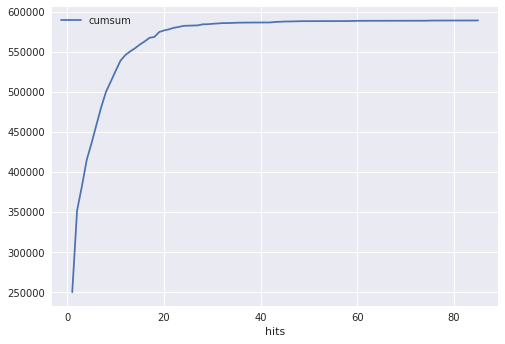

In [33]:
pd_sorted.plot(x='hits', y='cumsum')

In [34]:
df_ps_final = df_ps_final.drop("traceTimeentry")

In [35]:
categoricalFeatures = ['account', 'clientState', 'dataset', 'datasetScope', 'eventType', 'eventVersion', 'filename', 
                       'hostname', 'protocol', 'remoteSite', 'scope', 'traceId', 'traceIp', 'uuid', 'project', 
                       'run_number', 'stream_name', 'prod_step', 'datatype', 'dataset_version']

encoded = df_ps_final

for elem in categoricalFeatures:
    encoded = encoded.withColumn(elem + "Hash", hash(encoded[elem]))

In [36]:
encoded.describe().toPandas()

summary   account         clientState  \
0  count   589283    589283               
1  mean    None      None                 
2  stddev  None      None                 
3  min     abell     CannotAuthenticate   
4  max     zmarshal  SourceNotFound       

                                                                                           dataset  \
0  589283                                                                                            
1  None                                                                                              
2  None                                                                                              
3  data12_8TeV.00200805.physics_MinBias.recon.NTUP_MINBIAS.r4768                                     
4  mc16_valid.361034.Pythia8EvtGen_A2MSTW2008LO_minbias_inelastic_low.merge.HITS.e3581_s3028_s2939   

  datasetScope eventType eventVersion                            filename  \
0  589283       589283    589283       589283                               
1  None         None      None         None                                 
2  None         None      None         None                                 
3  data12_8TeV  download  1.14.10      AOD.05341490._000446.pool.root.1     
4  mc16_valid   download  1.16.1       log.14217468._003414.job.log.tgz.1   

                   hostname protocol                 remoteSite        scope  \
0  589283                    589283   589283                     589283        
1  None                      None     None                       None          
2  None                      None     None                       None          
3  ReCaS-ui-01.cs.infn.it    davs     AGLT2_CALIBDISK            data12_8TeV   
4  xenia.nevis.columbia.edu  srm      WUPPERTALPROD_SCRATCHDISK  mc16_valid    

                            traceId                    traceIp  \
0  589283                            589283                      
1  None                              None                        
2  None                              None                        
3  000006b4ce98452580a7493dba70ceb0  2001:1458:201:e4::100:28c   
4  ffffd5de42064e778bb14610ca50b1a6  ::ffff:91.239.204.45        

     traceTimeentryUnix         transferStart  \
0  589283                589283                 
1  1.5261951742501497E9  1.5261950767825081E9   
2  716920.4582917794     716914.0264712825      
3  1.525125633301146E9   1.524860531819739E9    
4  1.527803987107225E9   1.527803946887522E9    

                               uuid      project         run_number  \
0  589283                            589283       589283              
1  None                              None         350085.3422377267   
2  None                              None         47777.01099327565   
3  000397830f284c508523b44ed7d19aab  data12_8TeV  00200805            
4  fffe0a61b053499da59d19fa07de8bbd  mc16_valid   periodL             

                                   stream_name prod_step datatype  \
0  589283                                       589283    589283    
1  None                                         None      None      
2  None                                         None      None      
3  AlpgenJimmy_AUET2_CTEQ6L1_WenugammagammaNp0  PhysCont  AOD       
4  physics_ZeroBias                             simul     log       

  dataset_version               hits       filesize_double  \
0  589283          589283             589283                 
1  None            4.395322790577702  1.4339739956710258E9   
2  None            6.041694435706447  2.1931399445811996E9   
3  c1128_m1842     1                  9576.0                 
4  x563_m1972      85                 1.1976018886E10        

            accountHash        clientStateHash            datasetHash  \
0  589283                589283                 589283                  
1  -7.873822054121874E7  -1.0635692705599144E9  -1.4774623149099838E7   
2  1.130364022555488E9   2.7545692038495237E8   1.2687544178

In [ ]:
encoded.write.format("json").save("/user/sprenner/training_official_mai.json")